# **Setting toolkit folder as working directory**

In [2]:
%cd /content/drive/MyDrive/PERSONAL/Projects/ML/IMDB Movies Sentiment Analysis using CNNs,RNNs,LSTMs

/content/drive/MyDrive/PERSONAL/Projects/ML/IMDB Movies Sentiment Analysis using CNNs,RNNs,LSTMs


# **Importing essential libraries and functions**

In [6]:
! pip install keras
! pip install tensorflow


In [8]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split

 # **LOading Data**

In [9]:
movie_reviews = pd.read_csv("/content/drive/MyDrive/PERSONAL/Projects/ML/IMDB Movies Sentiment Analysis using CNNs,RNNs,LSTMs/IMDB.csv")

In [11]:
movie_reviews.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [12]:
movie_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [13]:
movie_reviews.isnull().values.any()

False

In [14]:
movie_reviews.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


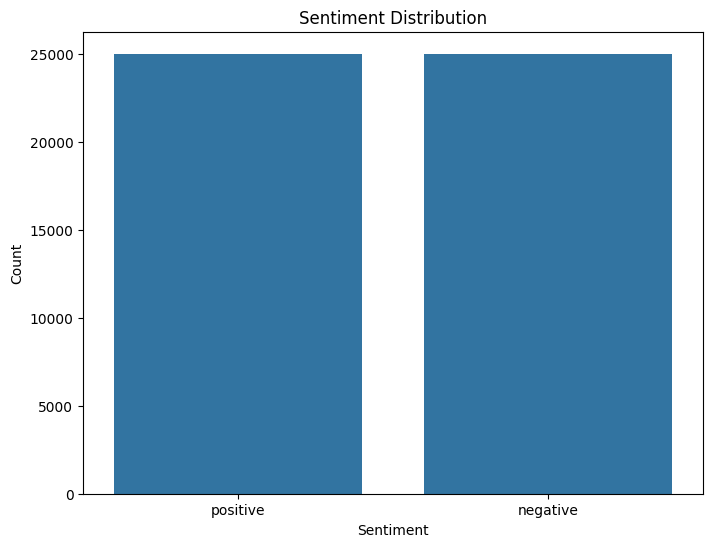

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(8, 6))
sns.countplot(movie_reviews, x='sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()



# **Data Preprocessing**

In [24]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [27]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [28]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [31]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

# Reviews are cleaned now

In [32]:
X[4]

'petter mattei love time money visually stunning film watch mr mattei offers us vivid portrait human relations movie seems telling us money power success people different situations encounter variation arthur schnitzler play theme director transfers action present time new york different characters meet connect one connected one way another next person one seems know previous point contact stylishly film sophisticated luxurious look taken see people live world live habitat thing one gets souls picture different stages loneliness one inhabits big city exactly best place human relations find sincere fulfillment one discerns case people encounter acting good mr mattei direction steve buscemi rosario dawson carol kane michael imperioli adrian grenier rest talented cast make characters come alive wish mr mattei good luck await anxiously next work '

In [33]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [34]:
X[1]

'wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

In [35]:
X[8000]

'graphics brilliant obviously stunning things definitely given away trailers fight sequences move extremely fast watching couple eyes used seem confusing cloud wide array swords kinda wish things moving little slower could see incredibly detailed oh finally get see exactly one equips materia music brilliant also bit nervous since seen nobuo best writing music go along action remember steal tiny bronco sequence brilliant fits perfectly glad preordered ost changed lyrics one winged angel though able sing along know carmina burana lyrics plot first half movie sets things introduces everyone fairly complex tapestry second half almost entirely fight sequences players place call weak plot nowhere near convoluted game plot think effort avoid trying overshadow game think good thing movie entity try top original terms sheer plot admit kind hoping movie would bring ff wider range people mainstream movie going give nine stars even really try explain anything newcomers marlene least think marlene 

In [36]:
# Converting sentiment labels to 0 & 1


y = movie_reviews["sentiment"]
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [37]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

# **Preparing embedding layer**

In [42]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [43]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [44]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [45]:
X_train

array([[32471,   121,   100, ...,    96,   232,  3671],
       [  299,    33,    83, ...,    22,  1545,    27],
       [ 1173,    35,     9, ...,     0,     0,     0],
       ...,
       [  648,     3,   259, ...,     0,     0,     0],
       [  234,    78,   706, ...,     0,     0,     0],
       [  402,     1,   144, ...,     0,     0,     0]], dtype=int32)

In [46]:
X_test

array([[   38, 40602,    42, ...,   154,    88,   839],
       [  276,  1064,   149, ...,   258,  8378,  7877],
       [    2,   774,   111, ...,     0,     0,     0],
       ...,
       [  303,   554, 24633, ...,   484,    74,  2792],
       [  116,    29,    51, ...,     0,     0,     0],
       [  105,  7918,    58, ...,     0,     0,     0]], dtype=int32)

In [48]:
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/SentimentAnalysis using CNNs, ANNs, LSTMs ,from Youtube/Youtube Sentiment Analysis Project CNNs,ANNs,LSTMs/a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [49]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [50]:
embedding_matrix.shape

(92394, 100)

# **Model Training**

## Simple Neural Network

In [51]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [52]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [53]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 6s 13ms/step - loss: 0.5578 - acc: 0.7134 - val_loss: 0.5110 - val_acc: 0.7492
Epoch 2/6
250/250 [==============================] - 2s 6ms/step - loss: 0.4494 - acc: 0.7943 - val_loss: 0.4908 - val_acc: 0.7682
Epoch 3/6
250/250 [==============================] - 1s 6ms/step - loss: 0.4126 - acc: 0.8153 - val_loss: 0.5029 - val_acc: 0.7624
Epoch 4/6
250/250 [==============================] - 2s 6ms/step - loss: 0.3895 - acc: 0.8282 - val_loss: 0.5068 - val_acc: 0.7632
Epoch 5/6
250/250 [==============================] - 1s 6ms/step - loss: 0.3760 - acc: 0.8365 - val_loss: 0.5274 - val_acc: 0.7536
Epoch 6/6
250/250 [==============================] - 2s 8ms/step - loss: 0.3653 - acc: 0.8411 - val_loss: 0.5379 - val_acc: 0.7535


In [54]:
# Predictions on the Test Set

score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 2ms/step - loss: 0.5696 - acc: 0.7460


In [55]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5695656538009644
Test Accuracy: 0.7459999918937683


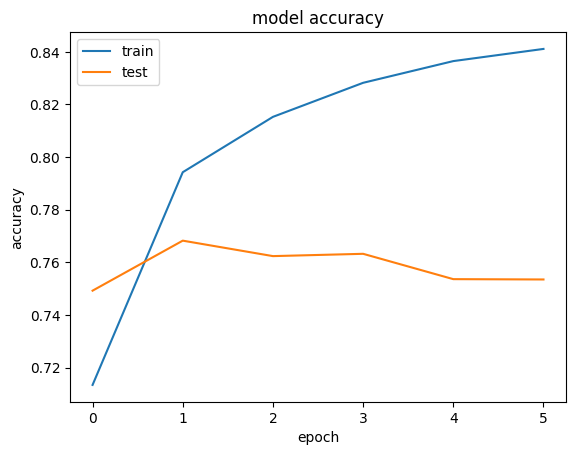

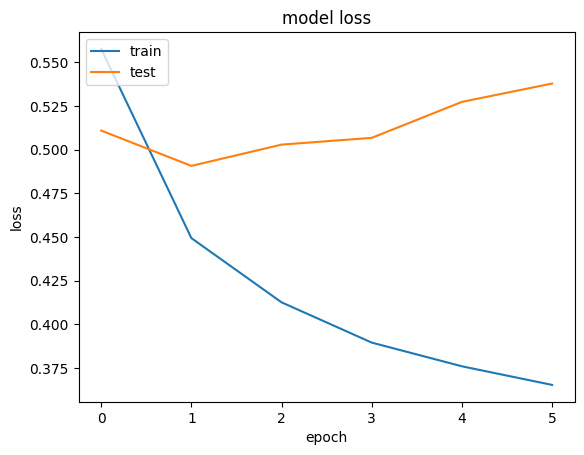

In [56]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# **Convolutional Neural Network (CNNs):**

In [57]:
from keras.layers import Conv1D

In [58]:
# Neural Network architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [59]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [60]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 30s 115ms/step - loss: 0.4701 - acc: 0.7690 - val_loss: 0.3803 - val_acc: 0.8347
Epoch 2/6
250/250 [==============================] - 25s 98ms/step - loss: 0.3413 - acc: 0.8528 - val_loss: 0.3495 - val_acc: 0.8457
Epoch 3/6
250/250 [==============================] - 27s 107ms/step - loss: 0.2833 - acc: 0.8871 - val_loss: 0.3355 - val_acc: 0.8508
Epoch 4/6
250/250 [==============================] - 28s 111ms/step - loss: 0.2408 - acc: 0.9097 - val_loss: 0.3392 - val_acc: 0.8480
Epoch 5/6
250/250 [==============================] - 24s 95ms/step - loss: 0.1998 - acc: 0.9320 - val_loss: 0.3390 - val_acc: 0.8505
Epoch 6/6
250/250 [==============================] - 27s 108ms/step - loss: 0.1652 - acc: 0.9499 - val_loss: 0.3305 - val_acc: 0.8529


In [61]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 7s 22ms/step - loss: 0.3348 - acc: 0.8559


In [62]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3348325788974762
Test Accuracy: 0.85589998960495


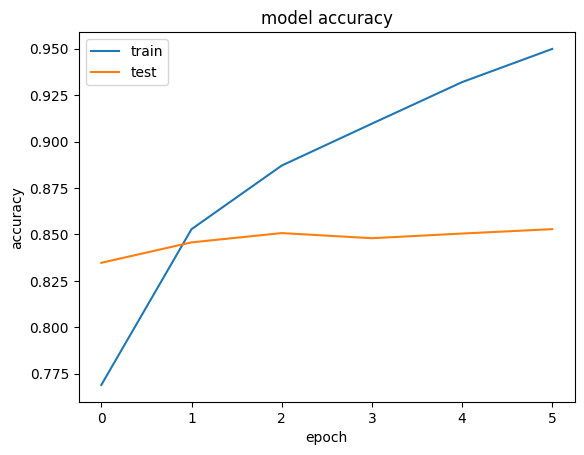

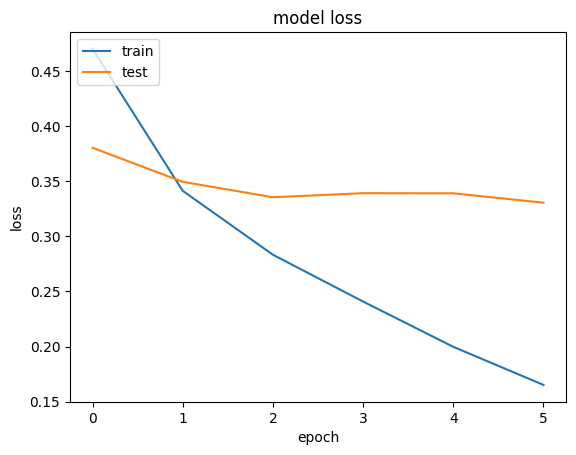

In [63]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# **Recurrent Neural Network (LSTM)**

In [64]:
from keras.layers import LSTM

In [65]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [66]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [67]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 93s 363ms/step - loss: 0.5014 - acc: 0.7547 - val_loss: 0.4644 - val_acc: 0.7947
Epoch 2/6
250/250 [==============================] - 91s 364ms/step - loss: 0.4143 - acc: 0.8154 - val_loss: 0.3808 - val_acc: 0.8364
Epoch 3/6
250/250 [==============================] - 85s 339ms/step - loss: 0.3708 - acc: 0.8387 - val_loss: 0.3522 - val_acc: 0.8479
Epoch 4/6
250/250 [==============================] - 89s 354ms/step - loss: 0.3391 - acc: 0.8540 - val_loss: 0.3445 - val_acc: 0.8555
Epoch 5/6
250/250 [==============================] - 86s 342ms/step - loss: 0.3187 - acc: 0.8668 - val_loss: 0.3583 - val_acc: 0.8496
Epoch 6/6
250/250 [==============================] - 88s 352ms/step - loss: 0.3044 - acc: 0.8758 - val_loss: 0.3261 - val_acc: 0.8658


In [68]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 18s 59ms/step - loss: 0.3222 - acc: 0.8638


In [69]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3221583068370819
Test Accuracy: 0.8637999892234802


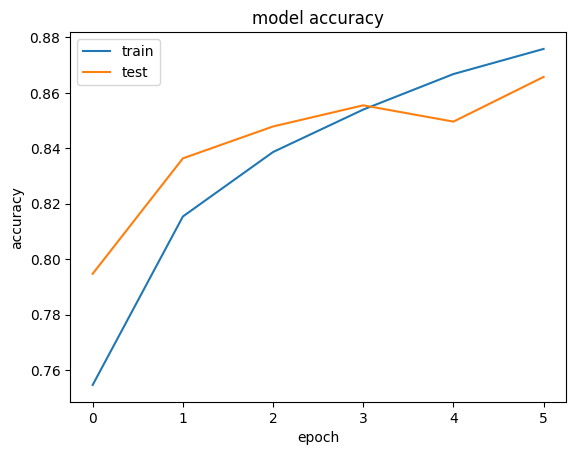

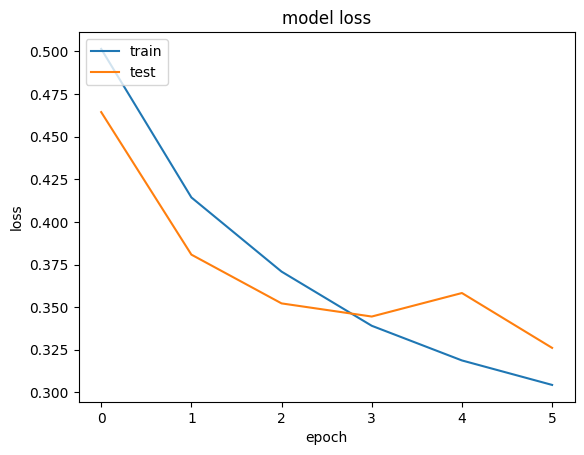

In [70]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Hence LSTMs is best model with briliant accuracy

In [71]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **Making Predictions on Live IMDb data**

In [72]:
!ls # lists files in working directory

c1_lstm_model_acc_0.864.h5  IMDB.csv


In [73]:
# # Load previously trained LSTM Model

# from keras.models import load_model

# model_path ='./c1_lstm_model_acc_0.856.h5'
# pretrained_lstm_model = load_model(model_path)

# # summarize model.
# pretrained_lstm_model.summary()

In [74]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

sample_reviews = pd.read_csv("/content/drive/MyDrive/SentimentAnalysis using CNNs, ANNs, LSTMs ,from Youtube/Youtube Sentiment Analysis Project CNNs,ANNs,LSTMs/a3_IMDb_Unseen_Reviews.csv")

sample_reviews.head(6)

,Unnamed: 0,Movie,Review Text,IMDb Rating
0,0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [75]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [76]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [77]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 645ms/step


array([[0.80609334],
       [0.9841676 ],
       [0.225888  ],
       [0.25646675],
       [0.9385611 ],
       [0.01118858]], dtype=float32)

In [78]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,8.1
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.8
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,2.3
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,2.6
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.4
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1



Al done...

---

